# 2.3 - 2.4 Combination of Yolo Model with Depth Estimation

## Idea: Combination of YOLO Model with Depth Estimation and Geolocation

- **Mapillary Data Fetching (Metadata) → 2.0**  
  The script fetches all objects from Zurich. Any blurry images are detected using `detect_blury_image.py` and marked with a boolean in the metadata file.  
  The `.gpkg` contains all relevant files.

- **Object Detection (YOLO) → 2.1**  
  The YOLO model detects objects in an image and marks them with bounding boxes.

- **Depth Estimation → 2.2**  
  For each detected object, the distance (depth) to the object is estimated.

- **Geolocation → 2.3**  
  The objects are displayed in a geographic context by showing their positions on a map.


## Task 1: Create a `.csv` with all file paths for the main script

Checking file paths:   0%|          | 0/1234551 [00:00<?, ?it/s]

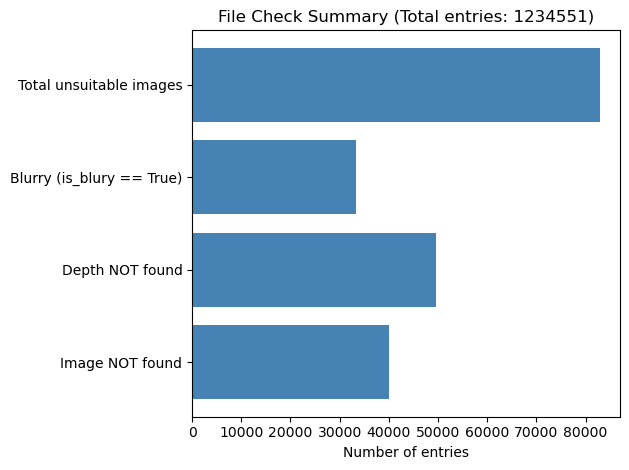

18

In [1]:
import os
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

# --- Configuration ---
IMAGE_DIR = r"D:\Mapillary_Data"
DEPTH_DIR = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_2_Model_Depth_Estimation\data\depth_processed"
GPKG_PATH = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_0_Fetch_Mapillary\data\images_bbox_fullmeta_with_blur.gpkg"

ID_FIELD = "id"
BLURY_FIELD = "is_blurry"
USE_COLS = [ID_FIELD, BLURY_FIELD]

# --- Load GeoPackage with only required columns ---
gdf = gpd.read_file(GPKG_PATH)

gdf[ID_FIELD] = gdf[ID_FIELD].astype(str)
gdf = gdf.set_index(ID_FIELD)

# --- Extract ID and blur status from GeoDataFrame ---
image_info = list(zip(gdf.index, gdf[BLURY_FIELD]))

# --- Path check function ---
def check_paths(args):
    img_id, is_blury = args
    image_path = os.path.join(IMAGE_DIR, f"{img_id}.jpg")
    depth_path = os.path.join(DEPTH_DIR, f"{img_id}.npz")
    return {
        "id": img_id,
        "image_path": image_path,
        "depth_path": depth_path,
        "has_image": os.path.exists(image_path),
        "has_depth": os.path.exists(depth_path),
        "is_blury": is_blury
    }

# --- Run parallel path check ---
records = []
with ThreadPoolExecutor() as executor:
    for result in tqdm(executor.map(check_paths, image_info), total=len(image_info), desc="Checking file paths"):
        records.append(result)

# --- Create DataFrame ---
df_files = pd.DataFrame(records)

# --- Define mask for unsuitable images ---
unsuitable_mask = (
    (df_files["is_blury"] == True) |
    (~df_files["has_image"]) |
    (~df_files["has_depth"])
)

# --- Summary with additional "unsuitable" entry ---
summary = {
    "Image NOT found": (~df_files["has_image"]).sum(),
    "Depth NOT found": (~df_files["has_depth"]).sum(),
    "Blurry (is_blury == True)": (df_files["is_blury"] == True).sum(),
    "Total unsuitable images": unsuitable_mask.sum()
}
total_entries = len(df_files)

# --- Plot ---
fig, ax = plt.subplots()
ax.barh(list(summary.keys()), list(summary.values()), color="steelblue")
ax.set_title(f"File Check Summary (Total entries: {total_entries})")
ax.set_xlabel("Number of entries")
plt.tight_layout()
plt.show()

# --- Filter valid entries ---
df_valid = df_files[
    (df_files["has_image"]) &
    (df_files["has_depth"]) &
    (df_files["is_blury"] == False)
].reset_index(drop=True)


df_valid.to_csv("./data/valid_images.csv", index=False)

import gc
gc.collect()


In [ ]:
import os
import shutil
import pandas as pd
from tqdm.notebook import tqdm

# --- Pfade ---
IMAGE_DIR = r"D:\Mapillary_Data"
SUITABLE_IMAGE_DIR = r"D:\Mapillary_Suitable"
if os.path.exists(SUITABLE_IMAGE_DIR):
    shutil.rmtree(SUITABLE_IMAGE_DIR)

df_suitable = df_files[
    (df_files["has_image"]) &
    (df_files["has_depth"]) &
    (df_files["is_blury"] == False)
]

df_suitable = df_suitable.reset_index(drop=True)
df_suitable.to_csv("./data/valid_images_with_yolo_labels.csv", index=False)



## Task 2: Do the Yolo Prediciton and combine the 2.0, 2.1 and the 2.2
We use the file `Geolocation.py` for it

In [ ]:
from config import (
    YOLO_MODEL_PATH,
    YOLO_OUTPUT_FOLDER,
    DEPTH_OUTPUT_FOLDER,
    IMAGE_FOLDER,
    OUTPUT_JSON_FOLDER,
    CSV_PATH,
    NUM_IMAGES_TO_SAMPLE,
    BATCH_SIZE,
    SUITABLE_IMAGE_FOLDER,
    DEPTH_METHOD,
    CATEGORY_METHOD,
    CATEGORY_THRESHOLDS,
    CONFIDENCE_THRESHOLD,
    PLOT,
    PLOT_OUTPUT_FOLDER,
    PLOT_OPTIONS,
    NUM_WORKERS,
    USE_NUMBA,
    GPKG_PATH
)
import logging
import time
from Geolocation import yolo_batch_inference_folder
from Geolocation import combine_yolo_depth
from Geolocation import add_geometry_to_parquet_fast
from ultralytics import YOLO
import pandas as pd
import os
import shutil
t0 = time.time()

logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

    # Step 1: Load CSV and filter already processed images
if NUM_IMAGES_TO_SAMPLE > 0:
    df_valid = pd.read_csv(CSV_PATH).sample(n=NUM_IMAGES_TO_SAMPLE, random_state=42)
else:
    df_valid = pd.read_csv(CSV_PATH)
df_valid_yolo = df_valid[
    ~df_valid["image_path"].apply(
        lambda p: os.path.exists(
                os.path.join(YOLO_OUTPUT_FOLDER, os.path.splitext(os.path.basename(p))[0] + ".npz")
            )
        )
    ].reset_index(drop=True)

logging.info(f"{len(df_valid) - len(df_valid_yolo)} images already processed – will be skipped.")

t0 = time.time()

t0 = time.time()

# Step 2: Run YOLO inference in batches
for i in range(0, len(df_valid_yolo), BATCH_SIZE):
    if os.path.exists(SUITABLE_IMAGE_FOLDER):
        shutil.rmtree(SUITABLE_IMAGE_FOLDER)
    os.makedirs(SUITABLE_IMAGE_FOLDER, exist_ok=True)

    df_batch = df_valid_yolo.iloc[i:i+BATCH_SIZE]
    image_batch = df_batch["image_path"].tolist()

    success_count = 0

    for img_rel_path in image_batch:
        src = os.path.join(IMAGE_FOLDER, img_rel_path)
        dst = os.path.join(SUITABLE_IMAGE_FOLDER, os.path.basename(img_rel_path))
        try:
            shutil.copy2(src, dst)
            success_count += 1
        except Exception as e:
            logging.error(f"Error copying {src}: {e}")

    # YOLO inference
    model = YOLO(YOLO_MODEL_PATH)
    yolo_batch_inference_folder(model, SUITABLE_IMAGE_FOLDER, YOLO_OUTPUT_FOLDER)

    batches_done = (i // BATCH_SIZE) + 1

    # Nur alle 5 Batches Zeitmessung und Logging
    if batches_done % 15 == 0:
        images_done = batches_done * BATCH_SIZE
        elapsed_time = time.time() - t0

        avg_speed = images_done / elapsed_time if elapsed_time > 0 else 0
        images_left = len(df_valid_yolo) - images_done
        est_time_left = images_left / avg_speed if avg_speed > 0 else 0

        logging.info(
            f"{batches_done} Batches abgeschlossen ({images_done}/{len(df_valid_yolo)} Bilder).\n"
            f"Durchschnittliche Geschwindigkeit: {avg_speed:.2f} Bilder/Sekunde\n"
            f"Geschätzte verbleibende Zeit: {est_time_left/60/60:.2f} Stunden"
        )
 
    # Step 3: Combine YOLO + Depth
os.makedirs(OUTPUT_JSON_FOLDER, exist_ok=True)
combine_yolo_depth(
        yolo_output_folder=YOLO_OUTPUT_FOLDER,
        depth_output_folder=DEPTH_OUTPUT_FOLDER,
        image_folder=IMAGE_FOLDER,
        output_parquet_path=os.path.join(OUTPUT_JSON_FOLDER, "combined_output.parquet"),
        image_list=[os.path.basename(p) for p in df_valid["image_path"]],
        depth_method=DEPTH_METHOD,
        category_method=CATEGORY_METHOD,
        category_thresholds=CATEGORY_THRESHOLDS,
        min_conf=CONFIDENCE_THRESHOLD,
        plot=PLOT,
        plot_output_folder=PLOT_OUTPUT_FOLDER,
        plot_kwargs=PLOT_OPTIONS,
        num_workers=NUM_WORKERS,
        use_numba=USE_NUMBA
    )


2025-08-07 09:32:02,167 [INFO] 1151693 images already processed – will be skipped.
2025-08-07 09:32:14,263 [INFO] 186954 Bilder bereits verarbeitet – werden übersprungen.
2025-08-07 09:32:14,331 [INFO] 🔄 Starting combination of 964739 images with YOLO + depth information...
2025-08-07 09:32:14,332 [INFO] 🚀 Using 24 workers for multiprocessing


Processing Images:   0%|          | 0/964739 [00:00<?, ?it/s]

2025-08-07 11:19:58,485 [INFO] ✅ Combination finished
2025-08-07 11:19:58,485 [INFO]   ➤ Processed images: 964738/964739
2025-08-07 11:19:58,485 [INFO]   ➤ Detected objects: 17953325
2025-08-07 11:19:58,485 [INFO]   ➤ Missing YOLO files: 0
2025-08-07 11:19:58,485 [INFO]   ➤ Missing depth files: 0
2025-08-07 11:19:58,487 [INFO]   ➤ Parquet file saved at: d:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_Geolocation\data\combined_results_json\combined_output.parquet
2025-08-07 11:19:58,487 [INFO]   ➤ Runtime: 6474.51 seconds
2025-08-07 11:19:58,487 [INFO]   ➤ Performance: 149.01 images/second
2025-08-07 11:20:01,364 [INFO] 📦 Using existing file: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_0_Fetch_Mapillary\data\images_bbox_basic_geometry.parquet
d:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_Geolocation\Geolocation.py:678: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `re

## Task 5: Join the Parquet and GPKG files with Mapillary metadata and create the Geolocation

**Note:**  
The coordinates of the taken photo do not represent the actual coordinates of the detected object.

---

### Already available
1. **.parquet** file containing all detected features from step *2_4 Geolocation*  
2. **.gpkg** file containing all metadata from the Mapillary dataset  

---

### Goal
1. Join both files with the Mapillary data.  
2. Develop an approach to accurately position the data points, since **photo location ≠ object location**.

---
### Heuristic
- Start from the camera point (computed_geometry).

-  For non-pano images, shift the point along the viewing ray:

    - Direction: computed_compass_angle (degrees from north, clockwise).

    - Lateral correction: use the bounding box center’s position in the image to add an in-FOV yaw offset.

    - Distance: class-based per z_class (e.g., near ≈ 10 m, medium ≈ 20 m, …).

- For pano images: keep the camera position (no single heading).

- Reproject to LV95 (EPSG:2056) first so meter shifts are correct.

---

Labels we dont need:

| 0 animal--bird                  | 1 animal--ground-animal           | 59 nature--mountain               | 60 nature--sand                  |
|----------------------------------|------------------------------------|------------------------------------|-----------------------------------|
| 61 nature--sky                   | 62 nature--snow                    | 63 nature--terrain                 | 65 nature--water                  |
| 66 object--banner                | 69 object--catch-basin             |             | 73 object--mailbox                 |
|          | 76 object--phone-booth             | 78 object--sign--advertisement     | 79 object--sign--ambiguous         |
|            | 83 object--sign--store             | 85 object--support--pole           | 88 object--support--utility-pole   |
|   | | 104 object--trash-can              | 106 object--vehicle--boat          |
| 109 object--vehicle--caravan     | 117 object--water-valve            | 118 void--car-mount                | 119 void--dynamic                  |
| 120 void--ego-vehicle            | 121 void--ground                   | 122 void--static                   |                                   |



In [1]:
import geo_process

class Args:
    pass

args = Args()
args.parquet = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_Geolocation\data\combined_results_json\combined_output_with_geometry.parquet"
args.gpkg = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_0_Fetch_Mapillary\data\images_bbox_fullmeta_with_blur.gpkg"
args.out_dir = "./data/geolocation_results"
args.image_width = 1024
args.fov = 90.0
args.workers = None
args.sample = None



import pandas as pd

df = pd.read_parquet(args.parquet)
print(df["z_class"].value_counts())

geo_process.main(args)


INFO | Reading Parquet (YOLO): D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_Geolocation\data\combined_results_json\combined_output_with_geometry.parquet


z_class
near         7458846
very near    6458125
medium       3491770
far           544584
Name: count, dtype: int64


INFO | Reading GPKG (Mapillary): D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_0_Fetch_Mapillary\data\images_bbox_fullmeta_with_blur.gpkg
INFO | Joined dataset saved: ./data/geolocation_results\joined_dataset.parquet (12118885 rows)
INFO | Processing 12118885 rows in 24 chunks...
INFO | Adjusted dataset saved: ./data/geolocation_results\adjusted_dataset.parquet (12118885 rows)
